In [1]:
import numpy as np
import torch
from tfrecord.torch.dataset import TFRecordDataset
from torch.utils.data import Dataset
import pandas as pd
from SupContrast.networks.resnet_big import SupConResNet
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from utils import cal_metric

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [3]:
description = {'id_seq': 'int', 'data_seq': 'int', 
                   'label': 'int'}
car_model = 'Spark'
data_path = f'../Data/Survival/TFrecord_{car_model}_w29_s10/1/'
index_path = None
batch_size = 1000
train_file = f'{data_path}/train.tfrecord'
train_dataset = TFRecordDataset(train_file, index_path, description, shuffle_queue_size=10000)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)

In [4]:
val_file = f'{data_path}/val.tfrecord'
batch_size = 1000
val_dataset = TFRecordDataset(val_file, index_path, description, shuffle_queue_size=10000)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

In [5]:
def change_state_dict(state_dict):
    """
    Because state dict in distributed GPU is different
    """
    new_state_dict = {}
    for k, v in state_dict.items():
        k = k.replace("module.", "")
        new_state_dict[k] = v
    return new_state_dict

In [7]:
import torch.optim as optim
from networks.simple_cnn import SupConCNN, LinearClassifier

# model = SupConCNN(feat_dim=128)
model = SupConResNet('resnet18')
save_path = './save/SupCon_resnet18_lr0.005_0.001_bs4096_300epoch_temp0.07_041522_144805_cosine_warm/models'
ckpt_epoch = 200
# model_path = f'{save_path}/last.pth'
model_path = f'{save_path}/ckpt_epoch_{ckpt_epoch}.pth'
ckpt = torch.load(model_path)
state_dict = ckpt['model']
state_dict = change_state_dict(state_dict)
model.load_state_dict(state_dict=state_dict)
model = model.cuda()

In [11]:
def extract_featues(loader, model):
    model.eval()
    raw_data = np.empty(shape=[0, 29*29])
    features = np.empty(shape=[0, 512])
    labels = np.empty(shape=[0])

    with torch.no_grad():
        for batch in iter(loader):
            batch_data, _, batch_labels = batch.values()
            raw_data = np.concatenate((raw_data, batch_data), axis=0)
            batch_data[batch_data == 0] = -1
            batch_data = batch_data.view(-1, 1, 29, 29)
            batch_data = batch_data.to(torch.float)
            batch_data = batch_data.cuda()
            embs = model.encoder(batch_data)
            embs = embs.cpu().numpy()
            features = np.concatenate((features, embs), axis=0)
            labels = np.concatenate((labels, batch_labels.squeeze()), axis=0)
            
    return raw_data, features, labels

In [12]:
classes = ['Normal', 'DoS', 'Fuzzy', 'Malfunction']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd',]
n_classes = len(classes)

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(n_classes):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(classes)

In [13]:
train_raw_data, train_data, train_labels = extract_featues(train_loader, model)
val_raw_data, val_data, val_labels = extract_featues(val_loader, model)

/home/dhkim1/miniconda3/envs/torch/lib/python3.7/site-packages/tfrecord/iterator_utils.py:83: UserWarning: Number of elements in the iterator is less than the queue size (N=10000).
  warnings.warn("Number of elements in the iterator is less than the "


In [14]:
print('Train size: ', len(train_raw_data))
print('Val size: ', len(val_raw_data))

Train size:  18614
Val size:  7981


In [15]:
raw_data = np.concatenate((train_raw_data, val_raw_data), axis=0)
total_embs = np.concatenate((train_data, val_data), axis=0)
total_labels = np.concatenate((train_labels, val_labels), axis=0)
print('Total size: ', len(raw_data))

Total size:  26595


In [16]:
tsne = TSNE(n_components=2, learning_rate='auto', init='random', n_jobs=-1)
new_embs = tsne.fit_transform(total_embs)

KeyboardInterrupt: 

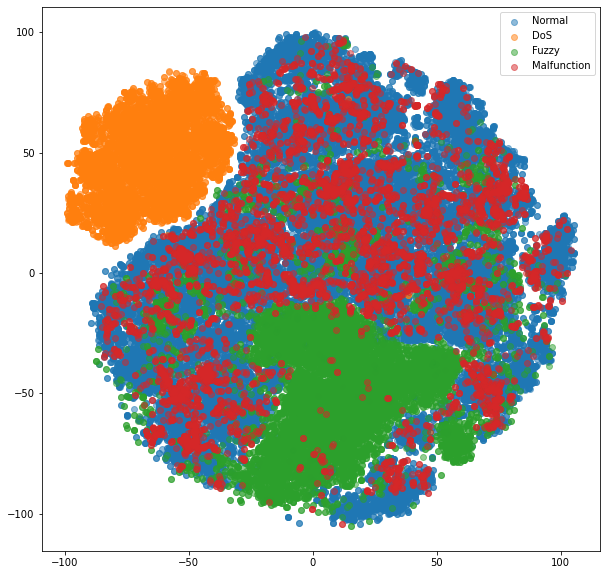

In [70]:
plot_embeddings(new_embs, total_labels)

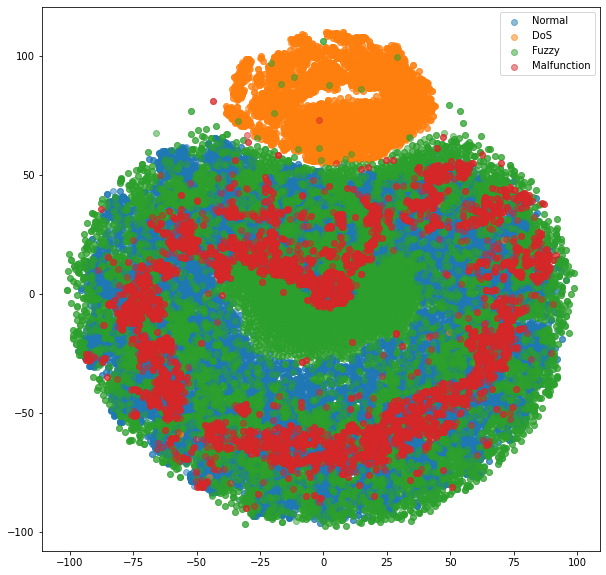

In [71]:
reduce_raw_data = tsne.fit_transform(raw_data)
plot_embeddings(reduce_raw_data, total_labels)

In [24]:
def stratified_cv(X, y, normalize=True, n_splits=3):
    skf = StratifiedKFold(n_splits=n_splits, random_state=123, shuffle=True)
    total_results = {}
    
    for it, (train_indx, test_indx) in enumerate(skf.split(X, y)):
        X_train, X_test = X[train_indx], X[test_indx]
        y_train, y_test = y[train_indx], y[test_indx]
        if normalize:
            scaler = StandardScaler().fit(X_train)
            X_train = scaler.transform(X_train)
            X_test = scaler.transform(X_test)
        clf = LogisticRegression(random_state=100, multi_class='multinomial',
                                 penalty='l2', max_iter=100,
                                solver='lbfgs')
        # clf = RandomForestClassifier(max_depth=10, random_state=100)
        clf = clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        cm, results = cal_metric(y_test, y_pred)
        print(f'CV : {it + 1}')
        for key, values in results.items():
            print(key, list("{0:0.4f}".format(i) for i in values)) 
            total_results.setdefault(key, [])
            total_results[key].append(values)
    return total_results       

In [25]:
results_cv = stratified_cv(raw_data, total_labels, normalize=True, n_splits=5)
results_cv = {k: np.stack(v, axis=0) for k, v in results_cv.items()}
for k, v in results_cv.items():
    print(k, list("{0:0.4f}".format(i) for i in v.mean(axis=0)))

/home/dhkim1/miniconda3/envs/torch/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


CV : 1
fnr ['0.7192', '0.0880', '15.3425', '0.8078']
rec ['0.9928', '0.9991', '0.8466', '0.9919']
pre ['0.9827', '1.0000', '0.9224', '0.9951']
f1 ['0.9877', '0.9996', '0.8829', '0.9935']


/home/dhkim1/miniconda3/envs/torch/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


CV : 2
fnr ['0.7194', '0.0880', '9.5628', '1.1309']
rec ['0.9928', '0.9991', '0.9044', '0.9887']
pre ['0.9872', '1.0000', '0.9298', '1.0000']
f1 ['0.9900', '0.9996', '0.9169', '0.9943']


/home/dhkim1/miniconda3/envs/torch/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


CV : 3
fnr ['1.1573', '0.0000', '13.1148', '0.6462']
rec ['0.9884', '1.0000', '0.8689', '0.9935']
pre ['0.9857', '1.0000', '0.8908', '0.9935']
f1 ['0.9870', '1.0000', '0.8797', '0.9935']


/home/dhkim1/miniconda3/envs/torch/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


CV : 4
fnr ['0.7507', '0.1757', '10.6849', '0.6462']
rec ['0.9925', '0.9982', '0.8932', '0.9935']
pre ['0.9872', '1.0000', '0.9261', '0.9968']
f1 ['0.9899', '0.9991', '0.9093', '0.9951']
CV : 5
fnr ['1.1261', '0.1759', '17.2603', '0.4839']
rec ['0.9887', '0.9982', '0.8274', '0.9952']
pre ['0.9808', '1.0000', '0.8856', '0.9952']
f1 ['0.9847', '0.9991', '0.8555', '0.9952']
fnr ['0.8945', '0.1055', '13.1931', '0.7430']
rec ['0.9911', '0.9989', '0.8681', '0.9926']
pre ['0.9847', '1.0000', '0.9109', '0.9961']
f1 ['0.9879', '0.9995', '0.8889', '0.9943']


/home/dhkim1/miniconda3/envs/torch/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [18]:
results_cv = stratified_cv(total_embs, total_labels, normalize=True, n_splits=5)
results_cv = {k: np.stack(v, axis=0) for k, v in results_cv.items()}
for k, v in results_cv.items():
    print(k, list("{0:0.4f}".format(i) for i in v.mean(axis=0)))

CV : 1
fnr ['0.1251', '0.3515', '58.9041', '85.7835']
rec ['0.9987', '0.9965', '0.4110', '0.1422']
pre ['0.8102', '0.9982', '0.9740', '1.0000']
f1 ['0.8946', '0.9974', '0.5780', '0.2489']
CV : 2
fnr ['0.1876', '0.0880', '55.3425', '85.4604']
rec ['0.9981', '0.9991', '0.4466', '0.1454']
pre ['0.8137', '1.0000', '0.9588', '1.0000']
f1 ['0.8965', '0.9996', '0.6093', '0.2539']
CV : 3
fnr ['0.0938', '0.2639', '55.4645', '87.2375']
rec ['0.9991', '0.9974', '0.4454', '0.1276']
pre ['0.8107', '1.0000', '0.9879', '0.9875']
f1 ['0.8951', '0.9987', '0.6139', '0.2260']
CV : 4
fnr ['0.2502', '0.2639', '58.4699', '86.2682']
rec ['0.9975', '0.9974', '0.4153', '0.1373']
pre ['0.8096', '1.0000', '0.9441', '1.0000']
f1 ['0.8938', '0.9987', '0.5769', '0.2415']
CV : 5
fnr ['0.0626', '0.2639', '58.3562', '86.6129']
rec ['0.9994', '0.9974', '0.4164', '0.1339']
pre ['0.8093', '1.0000', '0.9870', '1.0000']
f1 ['0.8943', '0.9987', '0.5857', '0.2361']
fnr ['0.1439', '0.2462', '57.3074', '86.2725']
rec ['0.9986'